<a href="https://colab.research.google.com/github/lior5egal/Deep-Learning-0512-436201/blob/main/HW1_Split_nb/EX1_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Practical**
This notebook implements a Convolutional Neural Network (CNN) in PyTorch for image classification using the FashionMNIST dataset.

---
### Overview:
- Importing necessary libraries.
- Loading and preprocessing the dataset.
- Defining CNN architectures with variations.
- Training and evaluating the models.
- Visualizing the training and testing accuracy.

## **1. Importing Libraries**
The necessary libraries for building and training the CNN are imported. We use:
- `torch` for creating and training neural networks.
- `numpy` for numerical computations.
- `matplotlib` for visualization.
- `torchvision` for accessing datasets and transformations.

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## **2. Check CUDA Availability**
We check if a GPU is available for faster training.

In [5]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## **3. Data Loading and Preprocessing**
We define:
- `num_workers`: Number of subprocesses for data loading.
- `batch_size`: Number of samples per batch.
- Transformations: Convert images to tensors and apply normalization.
- Load the FashionMNIST dataset and shuffle training indices.

In [6]:
num_workers = 0
batch_size = 60

train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()

train_data = datasets.FashionMNIST('FashionMNIST/raw/train-images-idx3-ubyte', train=True, download=True, transform=train_transform)
test_data = datasets.FashionMNIST('FashionMNIST/raw/t10k-images-idx3-ubyte', train=False, download=True, transform=test_transform)

# obtain training indices
num_train = len(train_data)
train_idx = list(range(num_train))
np.random.shuffle(train_idx)

# define samplers for obtaining training
train_sampler = SubsetRandomSampler(train_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

classes = ["T-shirt/top", \
           "Trouser",\
           "Pullover",\
           "Dress",\
           "Coat",\
           "Sandal",\
           "Shirt",\
           "Sneaker",\
           "Bag",\
           "Ankle boot"\
           ]

## **4. Data Visualization**
We display a batch of training images to visually confirm the data is loaded correctly.

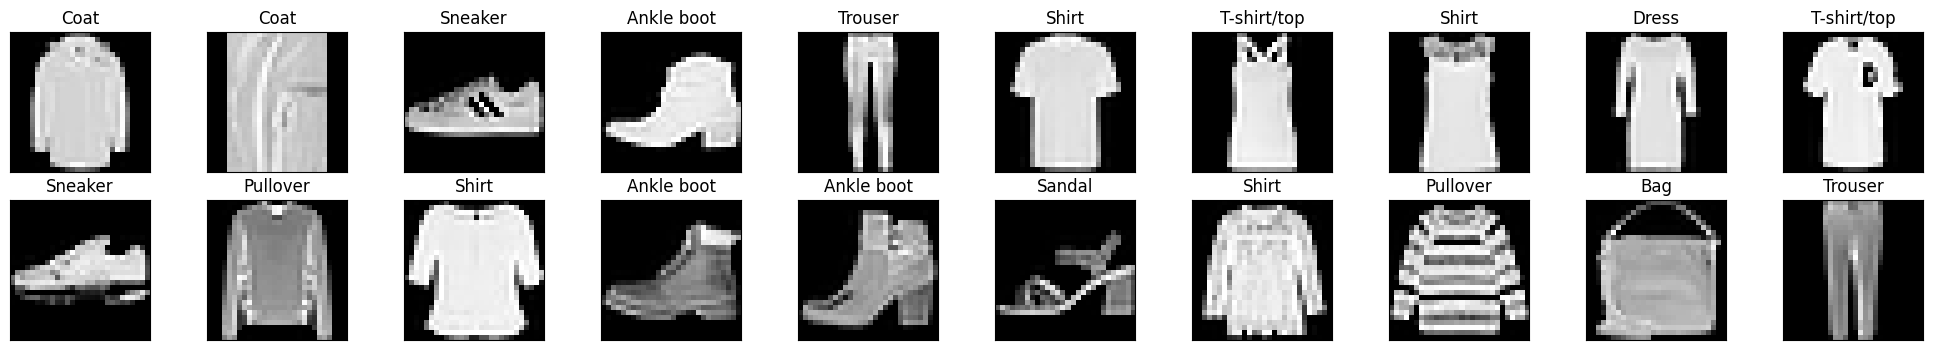

In [14]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)), cmap='gray')

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
num_of_images_to_display = 20
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(num_of_images_to_display):
    ax = fig.add_subplot(2, int(num_of_images_to_display/2), int(idx + 1), xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## **5. Defining CNN Architectures**
We define three variations of CNN models with dropout, batch normalization, and without any modifications. These architectures are essential for comparing different regularization techniques.


### **Convolutional Neural Network (CNN) Architecture with Dropout**

This section defines a CNN architecture named `Net_dropout`, designed for image classification tasks. The network incorporates multiple layers, including:

- **Convolutional Layers:** Extract spatial features from input images.
- **Average Pooling Layers:** Downsample feature maps to reduce dimensionality and computational cost.
- **Fully Connected Layers:** Perform high-level reasoning by mapping features to class scores.
- **Dropout Layers:** Prevent overfitting by randomly deactivating neurons during training.
- **Activation Functions:** ReLU for non-linearity and LogSoftmax for probabilistic output.

The network processes input images of size 28x28x1 and outputs a probability distribution over 10 classes. 

In [20]:
# define the CNN architecture
class Net_dropout(nn.Module):
    def __init__(self):
        super(Net_dropout, self).__init__()
        # convolutional layer (sees 28x28x1 -> 28x28x6 image tensor)
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        # convolutional layer (sees 14x14x6 -> 10x10x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        # Avg pooling layer
        self.pool = nn.AvgPool2d(2, 2)
        # linear layer (16 * 5 * 5 -> 120)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # linear layer (120 -> 84)
        self.fc2 = nn.Linear(120, 84)
        # linear layer (84 -> 10)
        self.fc3 = nn.Linear(84, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten image input
        x = x.view(-1, 16 * 5 * 5)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add another dropout layer
        x = self.dropout(x)
        # add 2st hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # fully connected for an output size
        x = self.fc3(x)
        # Log SoftMax activation function for output
        x= F.log_softmax(x, dim=1)
        return x

### **Convolutional Neural Network (CNN) Architecture**

This section defines a CNN architecture named `Net`, designed for image classification tasks. The network includes the following layers:

- **Convolutional Layers:** Extract spatial features from the input image.
- **Max Pooling Layers:** Reduce the spatial dimensions and retain key features, improving computational efficiency.
- **Fully Connected Layers:** Map the extracted features to class scores for classification.
- **Activation Functions:** ReLU is applied after each layer to introduce non-linearity, and LogSoftmax is used at the output for probabilistic predictions.

The network takes an input image of size 28x28x1 and produces a 10-class output.


In [21]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 28x28x1 -> 28x28x6 image tensor)
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        # convolutional layer (sees 14x14x6 -> 10x10x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        # Max pooling layer
        self.pool = nn.AvgPool2d(2, 2)
        # linear layer (16 * 5 * 5 -> 120)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # linear layer (120 -> 84)
        self.fc2 = nn.Linear(120, 84)
        # linear layer (84 -> 10)
        self.fc3 = nn.Linear(84, 10)




    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten image input
        x = x.view(-1, 16 * 5 * 5)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add 2st hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # fully connected for an output size
        x = self.fc3(x)
        # Log SoftMax activation function for output
        x= F.log_softmax(x, dim=1)
        return x

### **Convolutional Neural Network (CNN) Architecture with Batch Normalization**

This section defines a CNN architecture named `Net_BatchNorm`, designed for image classification tasks with batch normalization to enhance training stability and performance. The architecture includes:

- **Convolutional Layers:** Extract spatial features from the input image.
- **Batch Normalization Layers:** Normalize the outputs of convolutional layers, reducing internal covariate shift and accelerating training.
- **Max Pooling Layers:** Downsample feature maps to reduce spatial dimensions while preserving essential features.
- **Fully Connected Layers:** Map extracted features to class scores for classification.
- **Activation Functions:** ReLU introduces non-linearity after each layer, and LogSoftmax generates probabilistic outputs at the end.

The network takes an input image of size 28x28x1 and outputs a 10-class prediction.


In [22]:
# define the CNN architecture
class Net_BatchNorm(nn.Module):
    def __init__(self):
        super(Net_BatchNorm, self).__init__()
        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        # convolutional layer (sees 14x14x6 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        # batch normalization layer (for conv1)
        self.bn1 = nn.BatchNorm2d(6)
        # batch normalization layer (for conv2)
        self.bn2 = nn.BatchNorm2d(16)
        # max pooling layer
        self.pool = nn.AvgPool2d(2, 2)
        # linear layer (16 * 5 * 5 -> 120)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # linear layer (120 -> 10)
        self.fc2 = nn.Linear(120, 84)
        # linear layer (84 -> 10)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        # add sequence of convolutional, batch normalization and max pooling layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # flatten image input
        x = x.view(-1, 16 * 5 * 5)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add 2st hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # fully connected for an output size
        x = self.fc3(x)
        # Log SoftMax activation function for output
        x= F.log_softmax(x, dim=1)
        return x

## **6. Training Various CNN Models**
After defining the models, we proceed with training them using different configurations. Each model is trained for 15 epochs with the following setup:

### 1. Model Definition and Optimizer Setup
We define the models in the `models` list, which includes:
- `model_origin`: The basic model without dropout or batch normalization.
- `model_dropout`: The model with dropout to prevent overfitting.
- `model_batchnorm`: The model with batch normalization for improved training.
- `model_weightdecay`: The basic model with added weight decay for regularization.

For each model, we specify the loss function (`CrossEntropyLoss`) and the optimizer (`Adam`). In the case of `model_weightdecay`, weight decay is added to the optimizer to penalize large weights.


In [26]:
# create a various complete CNN
model_origin = Net()
model_dropout = Net_dropout()
model_batchnorm = Net_BatchNorm()
model_weightdecay = Net()

models = [(model_origin,"model_origin"), (model_dropout,"model_dropout"),
          (model_batchnorm,"model_batchnorm"),(model_weightdecay,"model_weightdecay")]

print(model_origin)
print(model_dropout)
print(model_batchnorm)
print(model_weightdecay)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Net_dropout(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
Net_BatchNorm(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, mo

### 2. Training Loop
We train each model for 15 epochs. During each epoch, we:
- Set the model to training mode.
- Load the data and perform a forward pass to compute the output.
- Calculate the loss and perform a backward pass to update the model parameters.
- Track the training loss and save the model weights after each epoch.


In [27]:
#training the different models
for i in range(4):

  #defining the wanted model
  model = models[i][0]
  print(models[i][1])

  # specify loss function (categorical cross-entropy)
  criterion = nn.CrossEntropyLoss()

  # specify optimizer
  if i != 3:
    optimizer = optim.Adam(model.parameters(), lr=0.002)
  else:
    optimizer = optim.Adam(model.parameters(), weight_decay = 0.0002, lr=0.002)

  # move tensors to GPU if CUDA is available
  if train_on_gpu:
      model.cuda()

  # number of epochs to train the model
  n_epochs = 15

  for epoch in range(1, n_epochs+1):

      # keep track of training and validation loss
      train_loss = 0.0

      ###################
      # train the model #
      ###################
      model.train()
      for data, target in train_loader:
          # move tensors to GPU if CUDA is available
          if train_on_gpu:
              data, target = data.cuda(), target.cuda()
          # clear the gradients of all optimized variables
          optimizer.zero_grad()
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # calculate the batch loss
          loss = criterion(output, target)
          # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          # perform a single optimization step (parameter update)
          optimizer.step()
          # update training loss
          train_loss += loss.item()*data.size(0)

      # calculate average losses
      train_loss = train_loss/len(train_loader.sampler)

      # print training/validation statistics
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(
          epoch, train_loss))

      # save model
      torch.save(model.state_dict(), f'{models[i][1]}_{epoch}.pt')

model_origin
Epoch: 1 	Training Loss: 0.612516
Epoch: 2 	Training Loss: 0.394835
Epoch: 3 	Training Loss: 0.334238
Epoch: 4 	Training Loss: 0.305534
Epoch: 5 	Training Loss: 0.280019
Epoch: 6 	Training Loss: 0.261752
Epoch: 7 	Training Loss: 0.248123
Epoch: 8 	Training Loss: 0.235465
Epoch: 9 	Training Loss: 0.224571
Epoch: 10 	Training Loss: 0.214654
Epoch: 11 	Training Loss: 0.204239
Epoch: 12 	Training Loss: 0.197775
Epoch: 13 	Training Loss: 0.187945
Epoch: 14 	Training Loss: 0.182316
Epoch: 15 	Training Loss: 0.174522
model_dropout
Epoch: 1 	Training Loss: 0.706230
Epoch: 2 	Training Loss: 0.498245
Epoch: 3 	Training Loss: 0.440101
Epoch: 4 	Training Loss: 0.405687
Epoch: 5 	Training Loss: 0.388692
Epoch: 6 	Training Loss: 0.372947
Epoch: 7 	Training Loss: 0.362682
Epoch: 8 	Training Loss: 0.354008
Epoch: 9 	Training Loss: 0.344595
Epoch: 10 	Training Loss: 0.341144
Epoch: 11 	Training Loss: 0.332130
Epoch: 12 	Training Loss: 0.325828
Epoch: 13 	Training Loss: 0.323097
Epoch: 14 	

## **7. Accuracy Evaluation of Each Model**

After training the models, we evaluate their performance on both training and testing datasets. For each model:
- We load the saved model weights from each epoch.
- We calculate the accuracy on both the training and testing datasets.
- We print the accuracy for each class and the overall accuracy.

In [29]:
#accuracys of per model models
accuracy = []

#testing various models
for idx in range(4):
  #defining the wanted model
  model = models[idx][0]
  print(f"\n{models[idx][1]}\n")

  # defining a list of accuracy per epoch with item's: [train_accuracy, test_accuracy]
  accuracy_model = []

  for epoch in range(1, n_epochs+1):
    print(f"\n*** epoch number: {epoch} ***\n")
    # loads the model
    model.load_state_dict(torch.load(f'{models[idx][1]}_{epoch}.pt'))
    # changing model into evaluation mode
    model.eval()

    # specify loss function (categorical cross-entropy)
    criterion = nn.CrossEntropyLoss()

    #list of current epoch's accuracy's
    epoch_accuracy = []

    # words list
    word_list = ["Train", "Test"]
    # switching between the training and testing loaders
    for idx_word,testing_data in enumerate([train_loader, test_loader]):

      ###################
      # test the model #
      ###################

      # track test loss
      test_loss = 0.0
      class_correct = list(0. for i in range(10))
      class_total = list(0. for i in range(10))


      # iterate over test data
      for data, target in testing_data:
          # move tensors to GPU if CUDA is available
          if train_on_gpu:
              data, target = data.cuda(), target.cuda()
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # calculate the batch loss
          loss = criterion(output, target)
          # update test loss
          test_loss += loss.item()*data.size(0)
          # convert output probabilities to predicted class
          _, pred = torch.max(output, 1)
          # compare predictions to true label
          correct_tensor = pred.eq(target.data.view_as(pred))
          correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
          # calculate test accuracy for each object class
          for i in range(min(batch_size, len(target.data))):
              label = target.data[i]
              class_correct[label] += correct[i].item()
              class_total[label] += 1

      # average test loss
      test_loss = test_loss/len(test_loader.dataset)
      print('--- {} Loss: {:.6f} ---\n'.format(word_list[idx_word],test_loss))

      for i in range(10):
          if class_total[i] > 0:
              print('%s Accuracy of %5s: %2d%% (%2d/%2d)' % (
                  word_list[idx_word],
                  classes[i], 100 * class_correct[i] / class_total[i],
                  np.sum(class_correct[i]), np.sum(class_total[i])))
          else:
              print('%s Accuracy of %5s: N/A (no training examples)' % (
                  word_list[idx_word],
                  classes[i]))

      # defining the current overall accuracy and adding it to: "epoch_accuracy"
      overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
      epoch_accuracy.append(overall_accuracy)

      print('\n ### %s Accuracy (Overall): %2d%% (%2d/%2d) ###\n' % (
          word_list[idx_word],
          overall_accuracy,
          np.sum(class_correct), np.sum(class_total)))

    # adding an epoch accuracies to: "accuracy_model"
    accuracy_model.append(epoch_accuracy)

  # adding accuracy_model to: "accuracy"
  accuracy.append(accuracy_model)




model_origin


*** epoch number: 1 ***



<ipython-input-29-b4fbe453b456>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{models[idx][1]}_{epoch}.pt'))


--- Train Loss: 2.545642 ---

Train Accuracy of T-shirt/top: 72% (4324/6000)
Train Accuracy of Trouser: 97% (5842/6000)
Train Accuracy of Pullover: 70% (4217/6000)
Train Accuracy of Dress: 87% (5272/6000)
Train Accuracy of  Coat: 84% (5053/6000)
Train Accuracy of Sandal: 94% (5659/6000)
Train Accuracy of Shirt: 56% (3416/6000)
Train Accuracy of Sneaker: 96% (5777/6000)
Train Accuracy of   Bag: 94% (5659/6000)
Train Accuracy of Ankle boot: 92% (5565/6000)

 ### Train Accuracy (Overall): 84% (50784/60000) ###

--- Test Loss: 0.455077 ---

Test Accuracy of T-shirt/top: 67% (677/1000)
Test Accuracy of Trouser: 96% (965/1000)
Test Accuracy of Pullover: 67% (676/1000)
Test Accuracy of Dress: 86% (866/1000)
Test Accuracy of  Coat: 83% (837/1000)
Test Accuracy of Sandal: 94% (940/1000)
Test Accuracy of Shirt: 55% (554/1000)
Test Accuracy of Sneaker: 95% (957/1000)
Test Accuracy of   Bag: 94% (940/1000)
Test Accuracy of Ankle boot: 91% (915/1000)

 ### Test Accuracy (Overall): 83% (8327/10000) 

## **8. Plotting Model Accuracy**

After evaluating the models, we plot the training and testing accuracies over all epochs for each model. This allows us to visualize the performance of each model during the training process.

model_origin


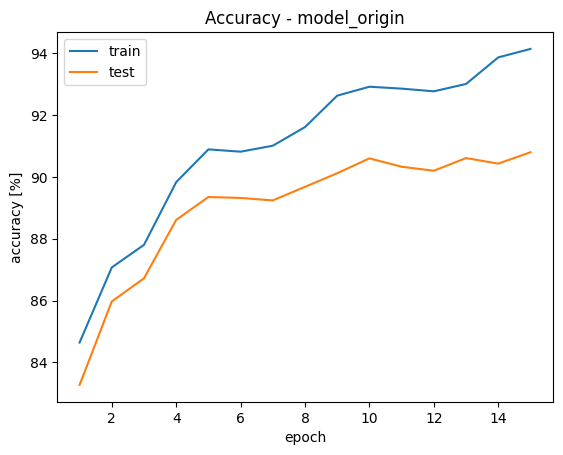

final train accuracy: 94.14166666666667
final test accuracy: 90.8

max train accuracy: 94.14166666666667 at epoch number 15
max test accuracy: 90.8 at epoch number 15

model_dropout


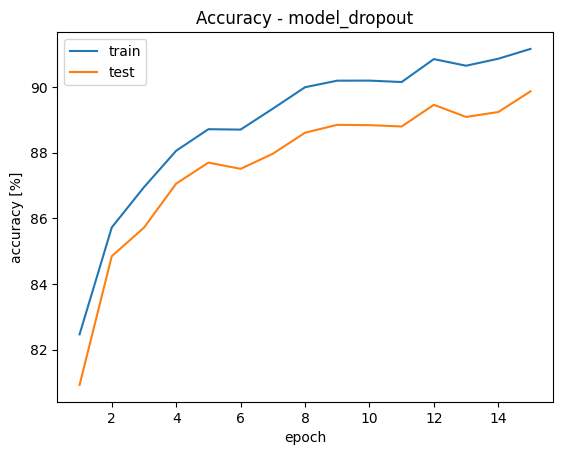

final train accuracy: 91.16166666666666
final test accuracy: 89.87

max train accuracy: 91.16166666666666 at epoch number 15
max test accuracy: 89.87 at epoch number 15

model_batchnorm


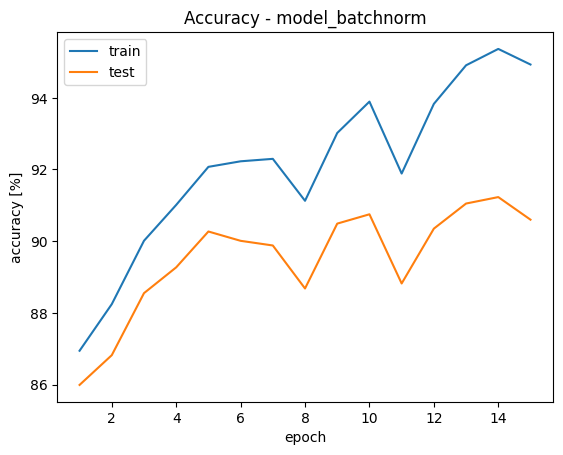

final train accuracy: 94.92833333333333
final test accuracy: 90.6

max train accuracy: 95.36333333333333 at epoch number 14
max test accuracy: 91.23 at epoch number 14

model_weightdecay


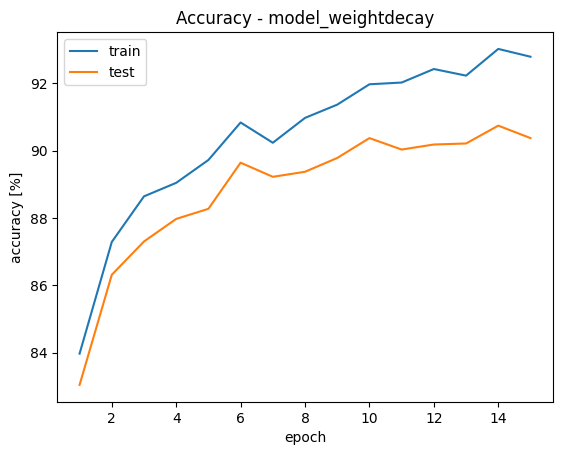

final train accuracy: 92.78666666666666
final test accuracy: 90.37

max train accuracy: 93.01833333333333 at epoch number 14
max test accuracy: 90.74 at epoch number 14



In [30]:
# iterating througth models accuracies
for idx, model_acc in enumerate(accuracy):
  print(models[idx][1])

  # extracting tran,test accuracies
  epoch_train_acc = [i[0] for i in model_acc]
  epoch_test_acc = [i[1] for i in model_acc]

  #plotting
  plt.plot([i for i in range(1,n_epochs + 1)], epoch_train_acc, label='train')
  plt.plot([i for i in range(1,n_epochs + 1)], epoch_test_acc, label='test')
  plt.legend()
  plt.xlabel('epoch')
  plt.ylabel('accuracy [%]')
  plt.title(f'Accuracy - {models[idx][1]}')
  plt.show()

  # gives each model it's final accuracy and max accuracy
  print(f"final train accuracy: {epoch_train_acc[-1]}")
  print(f"final test accuracy: {epoch_test_acc[-1]}\n")
  print(f"max train accuracy: {max(epoch_train_acc)} at epoch number {epoch_train_acc.index(max(epoch_train_acc))+1}")
  print(f"max test accuracy: {max(epoch_test_acc)} at epoch number {epoch_test_acc.index(max(epoch_test_acc))+1}\n")

## **9. Visualizing Model Predictions**

Finally, we visualize the predictions of the models on a batch of test images. We show the true labels and predicted labels for each image, and color the labels green if the prediction is correct or red if it is incorrect.

model_origin
model_dropout
model_batchnorm


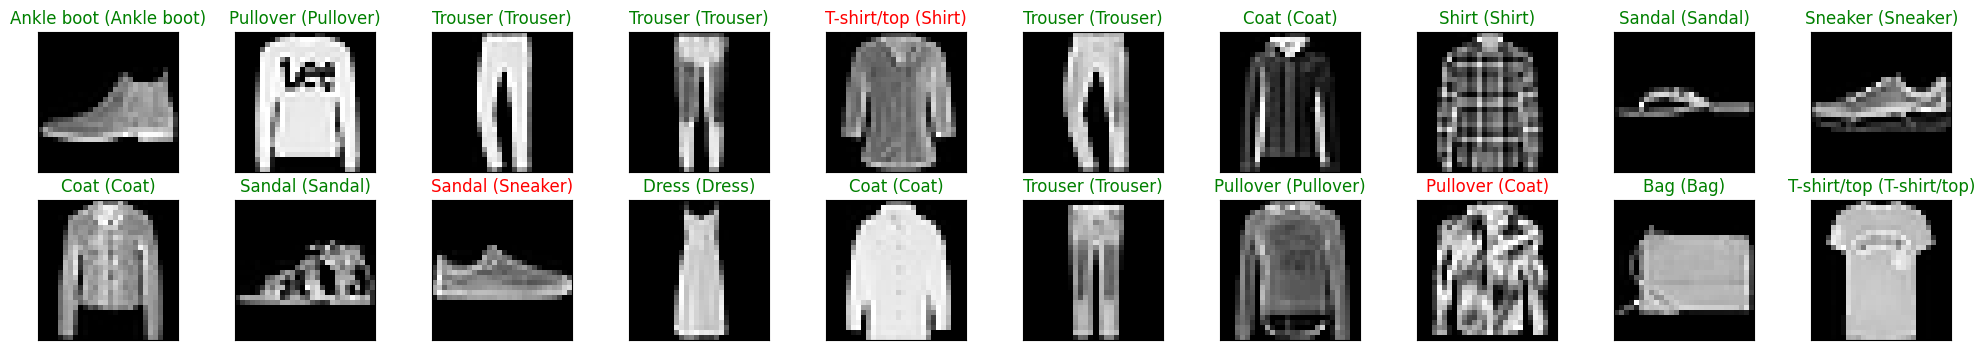

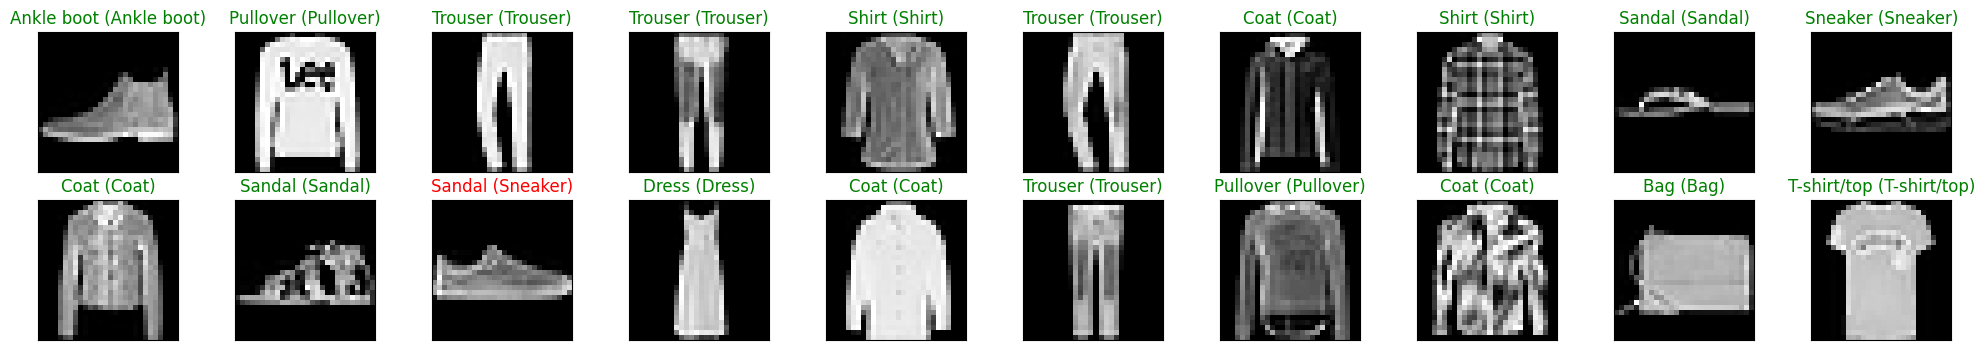

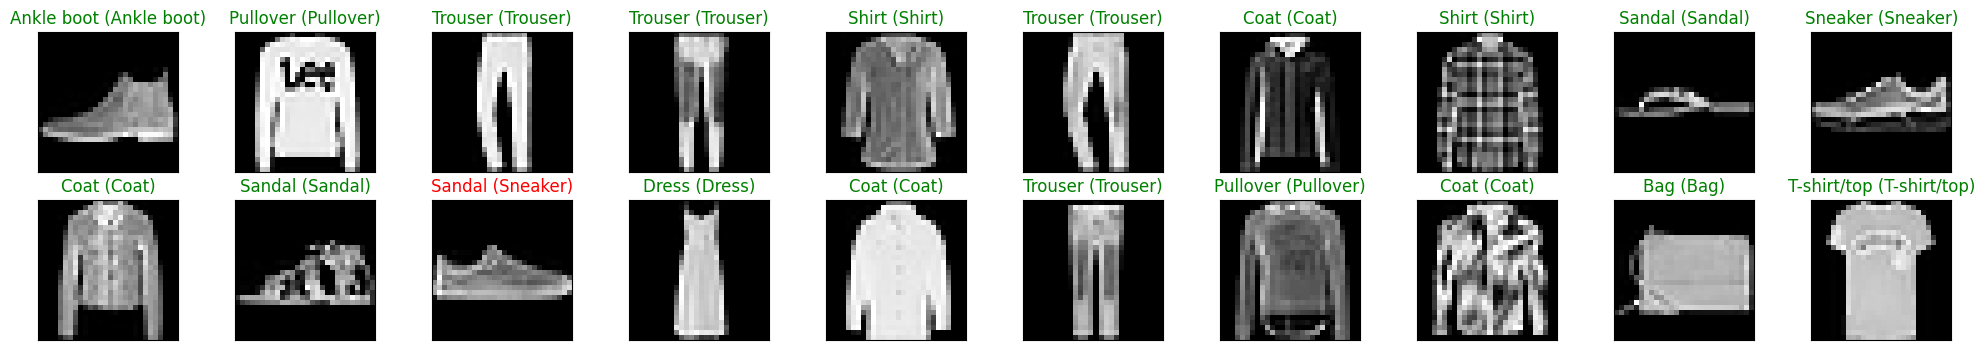

In [31]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

#testing various models
for i in range(3):
  if i < 3:
    #defining the wanted model
    model = models[i][0]
    print(models[i][1])

    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, int(20/2), int(idx+1), xticks=[], yticks=[])
        imshow(images[idx] if not train_on_gpu else images[idx].cpu())
        ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))